In [1]:
import os
import cv2
import uuid
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Input, Conv2D, Dense, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam


In [2]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_path)

In [3]:
def preprocessing(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img, channels=3)  # Force 3 channels
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    return img


In [4]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(300)

In [5]:
positive = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(200))))
negative = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(200))))
data = positive.concatenate(negative)

In [6]:
def process_triplet(anchor_img, val_img, label):
    return (preprocessing(anchor_img), preprocessing(val_img), label)

In [7]:
data = data.map(process_triplet).cache().shuffle(1024)
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [8]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [9]:
def make_embedding_model():
    input_image = Input(shape=(100, 100, 3))
    x = Conv2D(64, (10,10), activation='relu')(input_image)
    x = MaxPooling2D(64, (2,2), padding='same')(x)
    x = Conv2D(128, (7,7), activation='relu')(x)
    x = MaxPooling2D(64, (2,2), padding='same')(x)
    x = Conv2D(128, (4,4), activation='relu')(x)
    x = MaxPooling2D(64, (2,2), padding='same')(x)
    x = Conv2D(256, (4,4), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    return Model(input_image, x)

In [10]:
embedding_model = make_embedding_model()

In [11]:
embedding_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
class L1Dist(Layer):
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [13]:
input_image = Input(name='input_img', shape=(100, 100, 3))
validation_image = Input(name='validation_img', shape=(100, 100, 3))

In [14]:
distances = L1Dist()(embedding_model(input_image), embedding_model(validation_image))
output = Dense(1, activation='sigmoid')(distances)
siamese_model = Model(inputs=[input_image, validation_image], outputs=output)

In [15]:
# Prepare input format for training
train_data = train_data.map(lambda x1, x2, y: ((x1, x2), y))
test_data = test_data.map(lambda x1, x2, y: ((x1, x2), y))


In [17]:
siamese_model.compile(loss='binary_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])
siamese_model.fit(train_data, epochs=3, validation_data=test_data)


Epoch 1/3


18/18 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.8412 - loss: 0.7663 - val_accuracy: 0.9833 - val_loss: 0.0961
Epoch 2/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.9943 - loss: 0.0943 - val_accuracy: 0.9917 - val_loss: 0.0202
Epoch 3/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.9982 - loss: 0.0234 - val_accuracy: 1.0000 - val_loss: 0.0157


In [18]:
test_batch = train_data.as_numpy_iterator()

In [19]:

batch_1 = test_batch.next()

In [20]:
X = batch_1[:1]

In [21]:
X

((array([[[[1.        , 0.9980392 , 0.9705882 ],
           [0.92745095, 0.91764706, 0.91568625],
           [0.62058824, 0.60784316, 0.62058824],
           ...,
           [0.99509805, 1.        , 0.94215685],
           [0.9941176 , 1.        , 0.9411765 ],
           [0.9941176 , 1.        , 0.9470588 ]],
  
          [[0.99607843, 0.99509805, 0.96960783],
           [0.84607846, 0.8392157 , 0.82843137],
           [0.6098039 , 0.60490197, 0.6       ],
           ...,
           [0.99215686, 0.99607843, 0.92745095],
           [0.99215686, 0.9980392 , 0.92156863],
           [0.99215686, 0.9980392 , 0.92156863]],
  
          [[0.9990196 , 0.9980392 , 0.9745098 ],
           [0.75980395, 0.7558824 , 0.74607843],
           [0.59313726, 0.5892157 , 0.57941175],
           ...,
           [0.99607843, 1.        , 0.92745095],
           [0.99607843, 1.        , 0.92058825],
           [0.99607843, 1.        , 0.9196078 ]],
  
          ...,
  
          [[0.61764705, 0.54313725, 0.51

In [22]:
batch_1[1]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.],
      dtype=float32)

In [23]:
(anchor_batch, test_batch), label_batch = batch_1

print("Anchor shape:", anchor_batch.shape)
print("Test shape:", test_batch.shape)
print("Labels shape:", label_batch.shape)



Anchor shape: (16, 100, 100, 3)
Test shape: (16, 100, 100, 3)
Labels shape: (16,)


In [25]:
anchor_img = preprocessing(r'data/anchor/00a65d06-2005-11f0-b2fd-c09bd98a2a89.jpg')
test_img = preprocessing(r'C:\Users\91820\OneDrive\Desktop\face\data\negative\1 (2).jpeg')

# Expand dimensions to simulate batch size of 1
anchor_img = tf.expand_dims(anchor_img, axis=0)
test_img = tf.expand_dims(test_img, axis=0)


In [26]:
prediction = siamese_model.predict([anchor_img, test_img])
print("Prediction:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
Prediction: [[6.864533e-05]]


In [27]:
import cv2

In [28]:
def preprocessing(file_path_or_frame):
    if isinstance(file_path_or_frame, str):  # Load from file
        byte_img = tf.io.read_file(file_path_or_frame)
        img = tf.io.decode_jpeg(byte_img, channels=3)
    else:  # Assume it's an image/frame
        img = tf.convert_to_tensor(file_path_or_frame, dtype=tf.uint8)
        img = tf.image.resize(img, (100, 100))
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    return img

In [31]:
anchor_img = preprocessing(r'C:\Users\91820\OneDrive\Desktop\face\data\negative\1 (1).png')
anchor_img = tf.expand_dims(anchor_img, axis=0)

In [32]:
cap = cv2.VideoCapture(0)

print("Press 'v' to verify or 'q' to quit")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Show webcam feed
    cv2.imshow('Webcam - Press "v" to verify', frame)

    key = cv2.waitKey(1) & 0xFF

    if key == ord('v'):
        # Preprocess webcam frame
        test_img = preprocessing(frame)
        test_img = tf.expand_dims(test_img, axis=0)

        # Make prediction
        result = siamese_model.predict([anchor_img, test_img])
        print("Prediction:", result)

        if result > 0.5:
            print("✅ Face Verified - Same Person")
        else:
            print("❌ Face Not Verified - Different Person")

    elif key == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()

Press 'v' to verify or 'q' to quit
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Prediction: [[1.]]
✅ Face Verified - Same Person
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Prediction: [[1.]]
✅ Face Verified - Same Person


In [42]:
img=preprocessing(r'C:\Users\91820\OneDrive\Desktop\face\data\positive\1acd2a25-1eda-11f0-b249-c09bd98a2a89.jpg')

In [43]:
import matplotlib.pyplot as plt

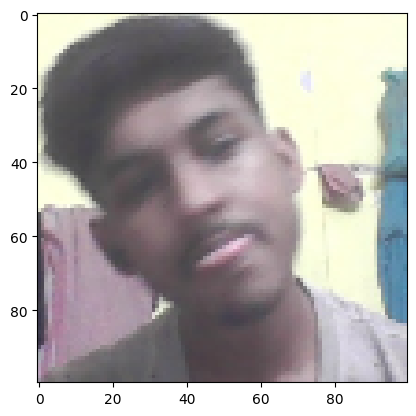

In [44]:
plt.imshow(img)